# 更开放、更友好、更快速的数据分析——python科学计算生态

## 题外话：更先进的包管理工具——[pixi](https://pixi.sh/latest/)

- `mamba`和`conda`可能是现在python中最流行的包管理器
- 但`mamba`和`conda`存在一些不足之处，如
  - 依赖解析慢：`mamba`比`conda`快很多，但仍有提升空间
  - 多环境管理不细致：多项目共用一个环境时，可能会出现包版本冲突
  - 原生不能保证环境的可复现性：不同机器或不同时间创建同一环境时，可能会出现包版本不一致的情况
  - ...
- `pixi`是近两年新发展的一个包管理器，针对它们的痛点做出了显著的改善
- `pixi`的安装方式与`mamba`类似，如
    ```shell
    curl -fsSL https://pixi.sh/install.sh | sh
    ```
    详见[官方文档](https://pixi.sh/latest/installation/)
- `pixi`的基本概念与`mamba`不同，它不是要创建一些全局的环境（尽管也可以这么做），而是以项目为单位来管理环境
- `pixi`初始化一个新项目
    ```shell
    pixi init my_workspace
    ```
    或初始化一个已有的项目
    ```shell
    pixi init .
    ```
- `pixi`往当前项目的默认环境里添加新的依赖包
    ```shell
    pixi add root==6.36 numpy>2 scipy matplotlib
    ```
    添加时，`pixi`会自动解析依赖关系并安装合适的版本，同时在lock文件中记录当前环境的完整状态，保证环境的可复现性
- `pixi`在当前项目的默认环境里运行程序
    ```shell
    pixi run python some_script.py
    ```
    或者直接开一个新的shell（类似`mamba`里的`activate`）
    ```shell
    pixi shell
    ```

## 为什么使用python进行数据分析？

- 基于一些历史原因，很多人喜欢用C++和C++的ROOT进行数据分析
- 但我们要做的是数据分析，不是类型检查、内存管理、编译链接等乱七八糟的底层事情
- python是一门高度动态的解释型语言，语法简洁、易读易写
- 而且python有着非常丰富且成熟的科学计算生态，涵盖了数据处理、统计分析、机器学习、可视化等各个方面
- python的科学计算生态让python在灵活的同时，也能拥有高效的计算能力
    ![Python Scientific Ecosystem](figures/shells-hep.svg)
    ![Python HEP Ecosystem](figures/shells-border.png)

## python科学计算生态的简单旅程

### 读写数据

使用`uproot`可以将ROOT文件中的数据直接读入为`numpy`数组或`pandas`表格（推荐）。在涉及到大量数组类型的数据时可以直接读取为`awkward-array`进行处理，更为方便。

下面以`pandas`为例进行说明。

In [1]:
import uproot

In [2]:
with uproot.open("data.root") as file:
    df = file["mytree"].arrays(library="pd")
df

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,324952.421175,-15922.14,3183.33,324505.26,5173.084
1,322646.890707,-15726.10,3140.21,322207.56,5106.995
2,330787.646146,-16161.34,3315.74,330336.42,5112.513
3,145366.494437,-20894.33,22863.39,141935.05,5153.103
4,139045.748263,-19992.46,21771.24,135770.00,5152.370
...,...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39,5134.590
39350,130065.701623,11638.66,-804.25,129439.65,5132.545
39351,458311.111414,24505.36,-2534.12,457619.56,5146.686
39352,456209.118547,24245.46,-2419.76,455528.68,5167.937


将数据保存到另一个文件

In [3]:
with uproot.recreate("data_output.root") as file:
    file["mytree"] = df.to_dict(orient="list")

/tmp/laf/ipykernel_2794199/728922956.py:2: FutureWarning: Starting in version 5.7.0, Uproot will default to writing RNTuples instead of TTrees. You will need to use `mktree` to explicitly create a TTree. This can be done by changing `file['tree_name'] = data` to `file.mktree('tree_name', data)`. Please update your code accordingly.
  file["mytree"] = df.to_dict(orient="list")


检查一下保存结果

In [4]:
import ROOT

file = ROOT.TFile("data_output.root")
file.ls()

TFile**		data_output.root	
 TFile*		data_output.root	
  KEY: TTree	mytree;1	


In [5]:
file.Get("mytree").Print()

******************************************************************************
*Tree    :mytree    :                                                        *
*Entries :    39354 : Total =         1577356 bytes  File  Size =    1039420 *
*        :          : Tree compression factor =   1.52                       *
******************************************************************************
*Br    0 :Bp_PE     : Bp_PE/D                                                *
*Entries :    39354 : Total  Size=     315399 bytes  File Size  =     300701 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.05     *
*............................................................................*
*Br    1 :Bp_PX     : Bp_PX/D                                                *
*Entries :    39354 : Total  Size=     315399 bytes  File Size  =     190553 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.65     *
*...................................................

### 打印数据的基本信息

打印基本信息，包括行列数、列的名称和数据类型等

In [6]:
df.shape

(39354, 5)

In [7]:
df.columns

Index(['Bp_PE', 'Bp_PX', 'Bp_PY', 'Bp_PZ', 'Bp_MM'], dtype='object')

In [8]:
df.dtypes

Bp_PE    float64
Bp_PX    float64
Bp_PY    float64
Bp_PZ    float64
Bp_MM    float64
dtype: object

打印出表格开头的少量数据

In [9]:
df.head(10)

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,324952.421175,-15922.14,3183.33,324505.26,5173.084
1,322646.890707,-15726.10,3140.21,322207.56,5106.995
2,330787.646146,-16161.34,3315.74,330336.42,5112.513
3,145366.494437,-20894.33,22863.39,141935.05,5153.103
4,139045.748263,-19992.46,21771.24,135770.00,5152.370
5,174077.713650,-2025.07,-6807.36,173857.14,5128.689
6,104592.330852,15437.57,-2779.09,103283.20,5110.429
7,102274.670858,15055.70,-2787.52,100992.46,5117.436
8,103203.708632,15338.42,-2957.08,101884.60,5150.661
9,101000.148010,14924.28,-2831.16,99719.43,5128.981


也可以用一些条件来筛选出部分列

In [10]:
df.filter(like="Bp_P")

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ
0,324952.421175,-15922.14,3183.33,324505.26
1,322646.890707,-15726.10,3140.21,322207.56
2,330787.646146,-16161.34,3315.74,330336.42
3,145366.494437,-20894.33,22863.39,141935.05
4,139045.748263,-19992.46,21771.24,135770.00
...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39
39350,130065.701623,11638.66,-804.25,129439.65
39351,458311.111414,24505.36,-2534.12,457619.56
39352,456209.118547,24245.46,-2419.76,455528.68


打印一些基本的统计量

In [11]:
df.describe()

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
count,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000
mean,181772.887332,124.477943,360.017913,181068.548891,5127.377275
std,83840.585911,10889.555137,9621.632925,83947.716034,38.542359
min,40189.717891,-53566.270000,-47012.970000,39621.130000,4813.602000
25%,119094.048916,-8786.272500,-7174.497500,118382.147500,5101.597250
50%,162836.492652,209.955000,772.955000,162122.465000,5129.660000
75%,227578.761177,9022.790000,7700.930000,227049.015000,5155.645750
max,775843.248929,40515.560000,43712.490000,775584.370000,5336.330000


### 索引和切片（取数据的子集）

`pandas`的`DataFrame`主要有五种索引和切片方式：`[]`、`.loc`、`.iloc`、`.at`和`.iat`。

- `[]`：可以用来选择列，也可以用来选择行（但不推荐）
    - 当`[]`里面是单个标签时，选择对应的列
    - 当`[]`里面是标签列表时，选择对应的多列
    - 当`[]`里面是切片（即类似`0:5`或`::-1`）时，选择对应的行
    - 当`[]`里面是布尔数组时，选择对应的行
    - 注意：`[]`不能同时选择行和列
- `.loc`：基于标签（行名或列名）进行索引和切片
- `.iloc`：基于整数位置（行号或列号）进行索引和切片
- `.at`：基于标签选择单个标量值
- `.iat`：基于整数位置选择单个标量值

In [12]:
df["Bp_MM"]

0        5173.084
1        5106.995
2        5112.513
3        5153.103
4        5152.370
           ...   
39349    5134.590
39350    5132.545
39351    5146.686
39352    5167.937
39353    5104.741
Name: Bp_MM, Length: 39354, dtype: float64

In [13]:
df[["Bp_PX", "Bp_PY"]]

,Bp_PX,Bp_PY
0,-15922.14,3183.33
1,-15726.10,3140.21
2,-16161.34,3315.74
3,-20894.33,22863.39
4,-19992.46,21771.24
...,...,...
39349,11093.65,-782.34
39350,11638.66,-804.25
39351,24505.36,-2534.12
39352,24245.46,-2419.76


In [14]:
df[0:5]

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,324952.421175,-15922.14,3183.33,324505.26,5173.084
1,322646.890707,-15726.10,3140.21,322207.56,5106.995
2,330787.646146,-16161.34,3315.74,330336.42,5112.513
3,145366.494437,-20894.33,22863.39,141935.05,5153.103
4,139045.748263,-19992.46,21771.24,135770.00,5152.370


In [15]:
df[df["Bp_MM"] > 5200]

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
152,126713.464715,8639.73,-16410.14,125240.90,5205.000
161,258539.042763,-5863.41,8604.77,258276.65,5212.847
205,167371.598504,-18619.41,-372.86,166250.66,5210.498
212,111847.572515,7384.31,6561.34,111288.65,5210.437
223,124134.725450,4247.50,16660.69,122827.84,5207.691
...,...,...,...,...,...
38967,125439.256933,-2795.31,-5183.77,125193.04,5200.407
38988,179462.404928,-9787.12,-3557.32,179084.15,5213.864
39157,125428.300999,-4848.29,-13268.77,124520.98,5217.434
39197,185905.073452,-12110.29,-319.18,185437.06,5201.156


In [16]:
df.loc[:, ["Bp_MM", "Bp_PX"]]

,Bp_MM,Bp_PX
0,5173.084,-15922.14
1,5106.995,-15726.10
2,5112.513,-16161.34
3,5153.103,-20894.33
4,5152.370,-19992.46
...,...,...
39349,5134.590,11093.65
39350,5132.545,11638.66
39351,5146.686,24505.36
39352,5167.937,24245.46


In [17]:
df.iloc[2]

Bp_PE    330787.646146
Bp_PX    -16161.340000
Bp_PY      3315.740000
Bp_PZ    330336.420000
Bp_MM      5112.513000
Name: 2, dtype: float64

In [18]:
df.iloc[2, 3]

np.float64(330336.42)

In [19]:
(df["Bp_MM"] > 5200).values

array([False, False, False, ..., False, False, False], shape=(39354,))

In [20]:
df.loc[df["Bp_MM"] > 5200, ["Bp_MM", "Bp_PX"]]

,Bp_MM,Bp_PX
152,5205.000,8639.73
161,5212.847,-5863.41
205,5210.498,-18619.41
212,5210.437,7384.31
223,5207.691,4247.50
...,...,...
38967,5200.407,-2795.31
38988,5213.864,-9787.12
39157,5217.434,-4848.29
39197,5201.156,-12110.29


In [21]:
df.iloc[(df["Bp_MM"] > 5200).values, 1:3]

,Bp_PX,Bp_PY
152,8639.73,-16410.14
161,-5863.41,8604.77
205,-18619.41,-372.86
212,7384.31,6561.34
223,4247.50,16660.69
...,...,...
38967,-2795.31,-5183.77
38988,-9787.12,-3557.32
39157,-4848.29,-13268.77
39197,-12110.29,-319.18


In [22]:
df.at[2, "Bp_PX"]

np.float64(-16161.34)

In [23]:
df.iat[2, 3]

np.float64(330336.42)

### 筛选数据

上面提到的布尔数组筛选其实就是数据筛选的一种方式。除此之外，还可以使用`pandas`的各种函数来进行更复杂的数据筛选操作。

`query`函数可以用字符串表达式来筛选数据

In [24]:
df.query("(Bp_MM > 5200) & (Bp_PX < 4000)")[["Bp_MM", "Bp_PX"]]

,Bp_MM,Bp_PX
161,5212.847,-5863.41
205,5210.498,-18619.41
285,5202.877,-9331.81
313,5200.335,-12982.16
540,5200.424,3285.91
...,...,...
38434,5210.779,-6893.69
38967,5200.407,-2795.31
38988,5213.864,-9787.12
39157,5217.434,-4848.29


`isin`函数可以用来筛选某列中包含特定值的行

In [25]:
df.isin([5200, 5300])

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
39349,False,False,False,False,False
39350,False,False,False,False,False
39351,False,False,False,False,False
39352,False,False,False,False,False


In [26]:
df.isin({"Bp_MM": [5200, 5300], "Bp_PX": [4000, 4100]})

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
39349,False,False,False,False,False
39350,False,False,False,False,False
39351,False,False,False,False,False
39352,False,False,False,False,False


`drop_duplicates`函数可以用来删除重复数据（在去除multiple candidates时很有用，如`df.drop_duplicates(["runNumber", "eventNumber"])`）

In [27]:
df.drop_duplicates()

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,324952.421175,-15922.14,3183.33,324505.26,5173.084
1,322646.890707,-15726.10,3140.21,322207.56,5106.995
2,330787.646146,-16161.34,3315.74,330336.42,5112.513
3,145366.494437,-20894.33,22863.39,141935.05,5153.103
4,139045.748263,-19992.46,21771.24,135770.00,5152.370
...,...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39,5134.590
39350,130065.701623,11638.66,-804.25,129439.65,5132.545
39351,458311.111414,24505.36,-2534.12,457619.56,5146.686
39352,456209.118547,24245.46,-2419.76,455528.68,5167.937


In [28]:
df.drop_duplicates(["Bp_MM", "Bp_PX"])

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM
0,324952.421175,-15922.14,3183.33,324505.26,5173.084
1,322646.890707,-15726.10,3140.21,322207.56,5106.995
2,330787.646146,-16161.34,3315.74,330336.42,5112.513
3,145366.494437,-20894.33,22863.39,141935.05,5153.103
4,139045.748263,-19992.46,21771.24,135770.00,5152.370
...,...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39,5134.590
39350,130065.701623,11638.66,-804.25,129439.65,5132.545
39351,458311.111414,24505.36,-2534.12,457619.56,5146.686
39352,456209.118547,24245.46,-2419.76,455528.68,5167.937


### 定义新列

在pandas中，可以通过简单的赋值操作来定义新列。例如，可以根据已有的列计算出新的物理量，并将其添加为新列。

In [29]:
df["Bp_P"] = (df["Bp_PX"] ** 2 + df["Bp_PY"] ** 2 + df["Bp_PZ"] ** 2) ** 0.5
df

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM,Bp_P
0,324952.421175,-15922.14,3183.33,324505.26,5173.084,324911.236955
1,322646.890707,-15726.10,3140.21,322207.56,5106.995,322606.389988
2,330787.646146,-16161.34,3315.74,330336.42,5112.513,330748.141976
3,145366.494437,-20894.33,22863.39,141935.05,5153.103,145275.139122
4,139045.748263,-19992.46,21771.24,135770.00,5152.370,138950.272573
...,...,...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39,5134.590,123452.337067
39350,130065.701623,11638.66,-804.25,129439.65,5132.545,129964.334403
39351,458311.111414,24505.36,-2534.12,457619.56,5146.686,458282.223229
39352,456209.118547,24245.46,-2419.76,455528.68,5167.937,456179.872278


也可以使用一些函数（如`apply`）来进行复杂的计算和转换。

In [30]:
def calculate_P(row):
    if row["Bp_MM"] > 5100:
        return (row["Bp_PX"] ** 2 + row["Bp_PY"] ** 2 + row["Bp_PZ"] ** 2) ** 0.5
    else:
        return 0


df["Bp_P_conditional"] = df.apply(calculate_P, axis=1)
df

,Bp_PE,Bp_PX,Bp_PY,Bp_PZ,Bp_MM,Bp_P,Bp_P_conditional
0,324952.421175,-15922.14,3183.33,324505.26,5173.084,324911.236955,324911.236955
1,322646.890707,-15726.10,3140.21,322207.56,5106.995,322606.389988,322606.389988
2,330787.646146,-16161.34,3315.74,330336.42,5112.513,330748.141976,330748.141976
3,145366.494437,-20894.33,22863.39,141935.05,5153.103,145275.139122,145275.139122
4,139045.748263,-19992.46,21771.24,135770.00,5152.370,138950.272573,138950.272573
...,...,...,...,...,...,...,...
39349,123559.067653,11093.65,-782.34,122950.39,5134.590,123452.337067,123452.337067
39350,130065.701623,11638.66,-804.25,129439.65,5132.545,129964.334403,129964.334403
39351,458311.111414,24505.36,-2534.12,457619.56,5146.686,458282.223229,458282.223229
39352,456209.118547,24245.46,-2419.76,455528.68,5167.937,456179.872278,456179.872278


不过`apply`的效率较低，建议尽量使用向量化的操作来提高性能。

### 画图

在python中，画图主要使用`matplotlib`包。`matplotlib`功能强大且灵活，可以满足各种复杂的绘图需求。也可以使用一些基于`matplotlib`的高级绘图库，如`seaborn`、`mplhep`等，来简化绘图过程并提升图形美观度。

In [31]:
import matplotlib.pyplot as plt
import mplhep as mh
import numpy as np
import seaborn as sns

一维直方图

Text(0, 0.5, 'Entries')

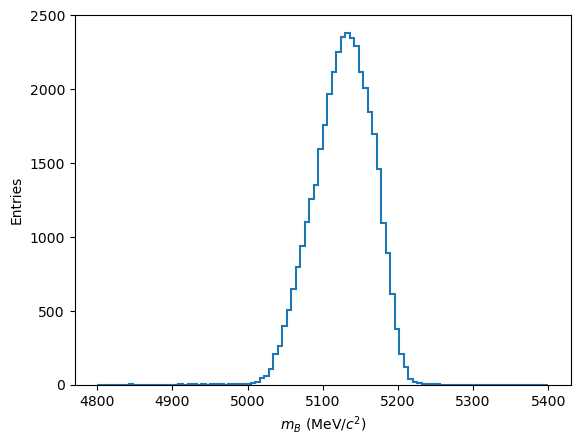

In [32]:
fig, ax = plt.subplots()
mh.histplot(np.histogram(df["Bp_MM"], range=(4800, 5400), bins=100), ax=ax)
ax.set_xlabel(r"$m_B \  (\mathrm{MeV}/c^2)$")
ax.set_ylabel("Entries")

或LHCb风格且带errorbar的一维直方图

Text(0, 1, 'Entries')

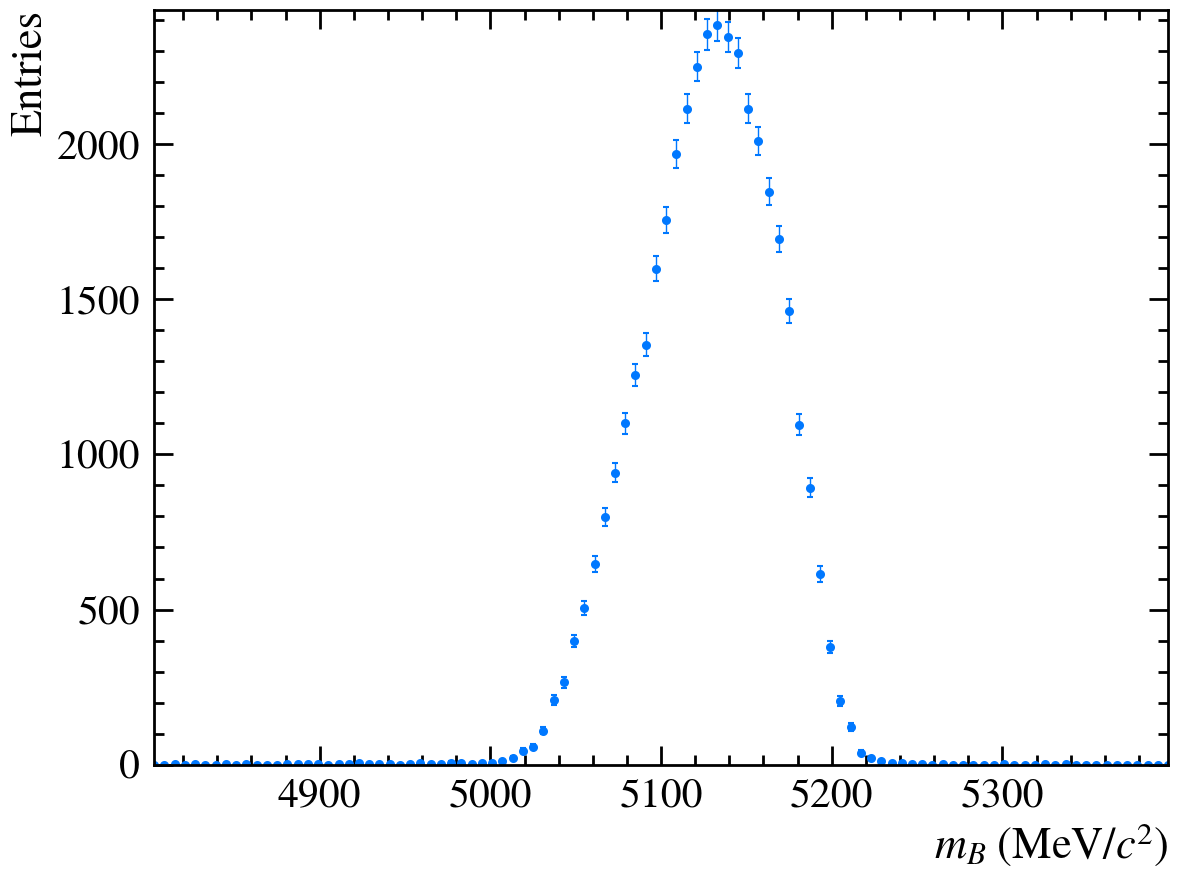

In [33]:
mh.style.use("LHCb2")

fig, ax = plt.subplots()
mh.histplot(
    np.histogram(df["Bp_MM"], range=(4800, 5400), bins=100),
    ax=ax,
    histtype="errorbar",
    yerr=True,
)
ax.set_xlabel(r"$m_B \  (\mathrm{MeV}/c^2)$")
ax.set_ylabel("Entries")

二维直方图

Text(15.444444444444473, 1, '$p_y \\  (\\mathrm{MeV}/c)$')

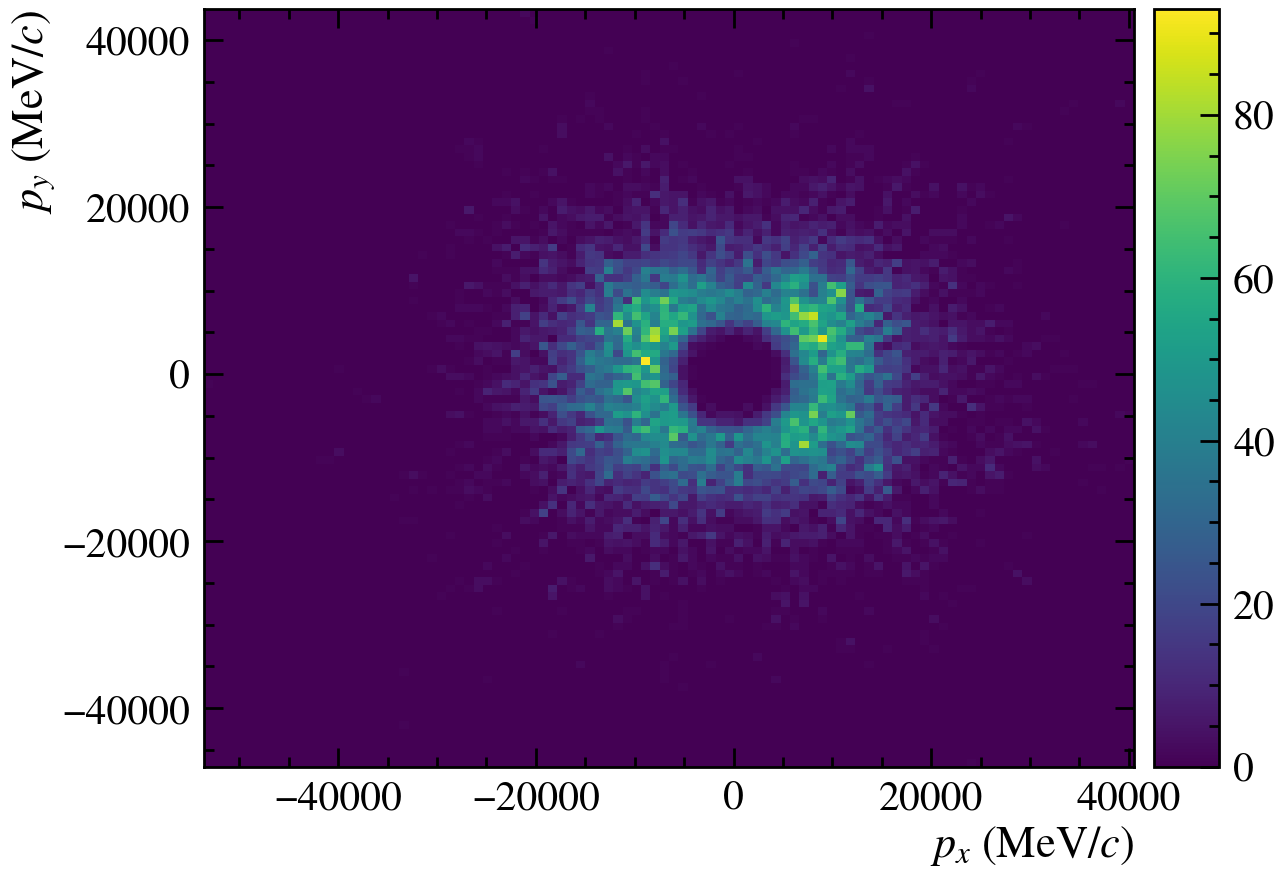

In [34]:
fig, ax = plt.subplots()
mh.hist2dplot(
    np.histogram2d(df["Bp_PX"], df["Bp_PY"], bins=100),
    ax=ax,
)
ax.set_xlabel(r"$p_x \  (\mathrm{MeV}/c)$")
ax.set_ylabel(r"$p_y \  (\mathrm{MeV}/c)$")

也可以用`seaborn`来画二维直方图

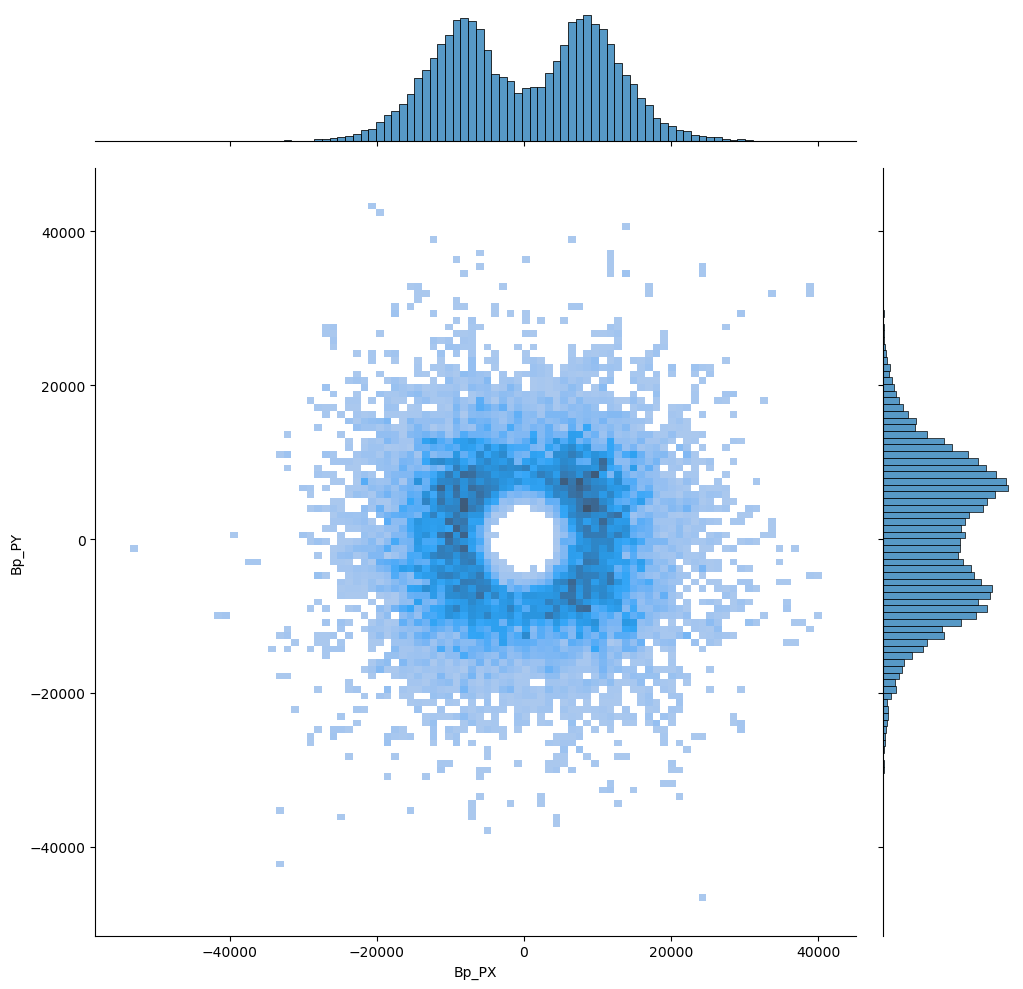

In [35]:
mh.style.use()  # reset to default style
sns.jointplot(data=df, x="Bp_PX", y="Bp_PY", kind="hist", height=10)

画关联矩阵

<Axes: >

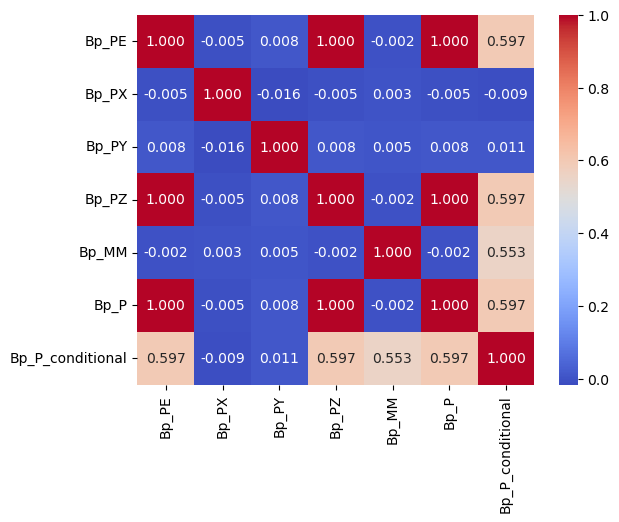

In [36]:
fig, ax = plt.subplots()
sns.heatmap(
    df.corr(),
    ax=ax,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
)

画散点图

Text(0, 0.5, '$p_y \\  (\\mathrm{MeV}/c)$')

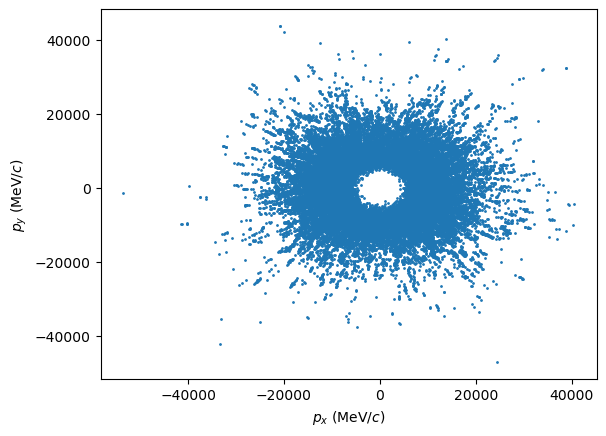

In [37]:
fig, ax = plt.subplots()
ax.scatter(df["Bp_PX"], df["Bp_PY"], s=1)
ax.set_xlabel(r"$p_x \  (\mathrm{MeV}/c)$")
ax.set_ylabel(r"$p_y \  (\mathrm{MeV}/c)$")

也可以用`seaborn`来画散点图

<Axes: xlabel='Bp_PX', ylabel='Bp_PY'>

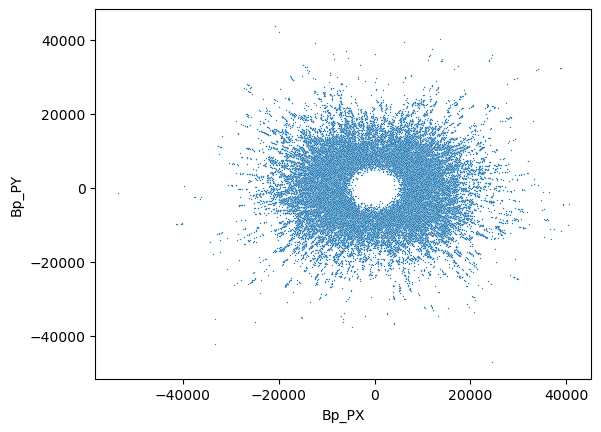

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="Bp_PX", y="Bp_PY", s=1, ax=ax)

### 多变量分析（MVA）

在python中有许多强大的机器学习库，如`scikit-learn`、`XGBoost`、`LightGBM`等，可以用来进行多变量分析（MVA）。这些库提供了丰富的算法和工具，方便我们进行分类、回归、聚类等任务。下面以`xgboost`为例，简单介绍如何进行分类任务。

In [39]:
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay, accuracy_score
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneGroupOut,
    cross_validate,
    train_test_split,
)

#### 构造信号样本和本底样本

In [40]:
df["Bp_PT"] = (df["Bp_PX"] ** 2 + df["Bp_PY"] ** 2) ** 0.5

signal_data = df[["Bp_P", "Bp_PT"]]
signal_data["label"] = 1
signal_data

/tmp/laf/ipykernel_2794199/3579200578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_data["label"] = 1


,Bp_P,Bp_PT,label
0,324911.236955,16237.245212,1
1,322606.389988,16036.556365,1
2,330748.141976,16497.970855,1
3,145275.139122,30972.691656,1
4,138950.272573,29558.168888,1
...,...,...,...
39349,123452.337067,11121.201653,1
39350,129964.334403,11666.414387,1
39351,458282.223229,24636.039310,1
39352,456179.872278,24365.909978,1


In [41]:
# construct background data by sampling from uniform distributions
import pandas as pd

bg_size = len(signal_data)
bg_data = pd.DataFrame(
    {
        "Bp_P": np.random.uniform(low=0, high=8e5, size=bg_size),
        "Bp_PT": np.random.uniform(low=0, high=5e4, size=bg_size),
    }
)
bg_data["label"] = 0
bg_data

,Bp_P,Bp_PT,label
0,567997.367398,22887.117954,0
1,205627.924735,13580.894886,0
2,168335.795714,20966.641862,0
3,299882.885773,46581.584074,0
4,140940.114965,13998.149571,0
...,...,...,...
39349,200482.804337,28728.798477,0
39350,552775.999803,40622.534673,0
39351,423564.137982,28034.846935,0
39352,193233.066277,12784.593843,0


In [42]:
data = pd.concat([signal_data, bg_data], ignore_index=True)
data["label"] = data["label"].astype("category")
data["fold"] = np.random.randint(0, 5, size=len(data))
data

,Bp_P,Bp_PT,label,fold
0,324911.236955,16237.245212,1,4
1,322606.389988,16036.556365,1,3
2,330748.141976,16497.970855,1,2
3,145275.139122,30972.691656,1,1
4,138950.272573,29558.168888,1,3
...,...,...,...,...
78703,200482.804337,28728.798477,0,2
78704,552775.999803,40622.534673,0,3
78705,423564.137982,28034.846935,0,0
78706,193233.066277,12784.593843,0,0


#### 将数据划分成训练集和测试集

In [43]:
x_train, x_test, y_train, y_test = train_test_split(
    data[["Bp_P", "Bp_PT"]], data["label"], test_size=0.3, random_state=42
)

#### 画出训练变量的一些图

<Axes: >

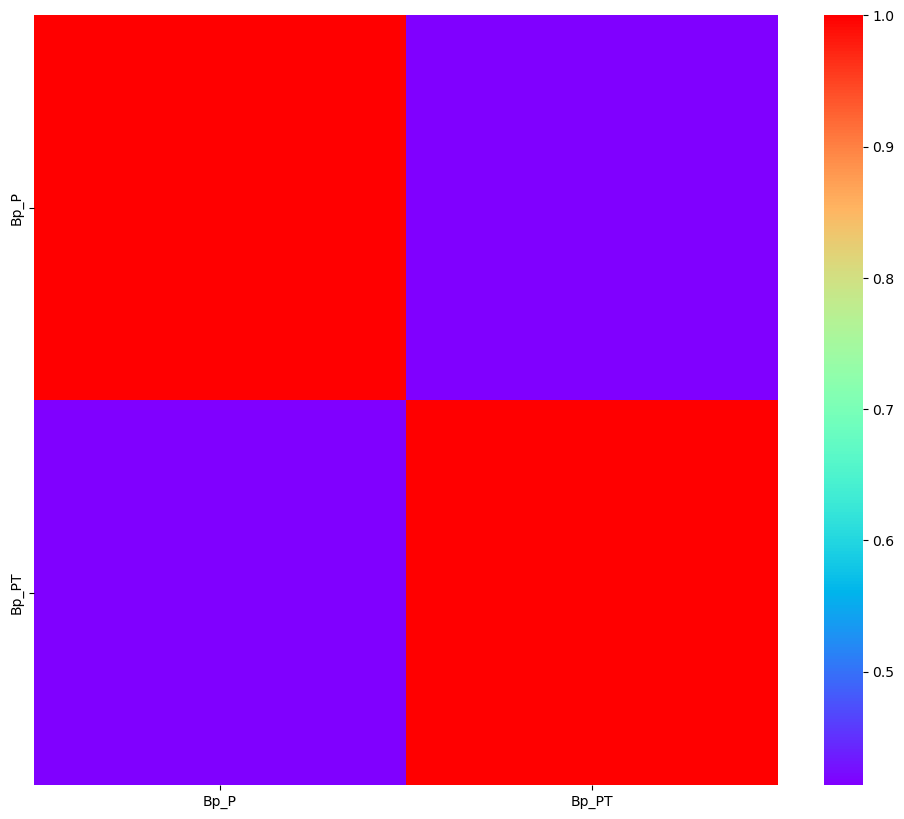

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))
corr = signal_data[["Bp_P", "Bp_PT"]].corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True, ax=ax, cmap="rainbow")

<Axes: >

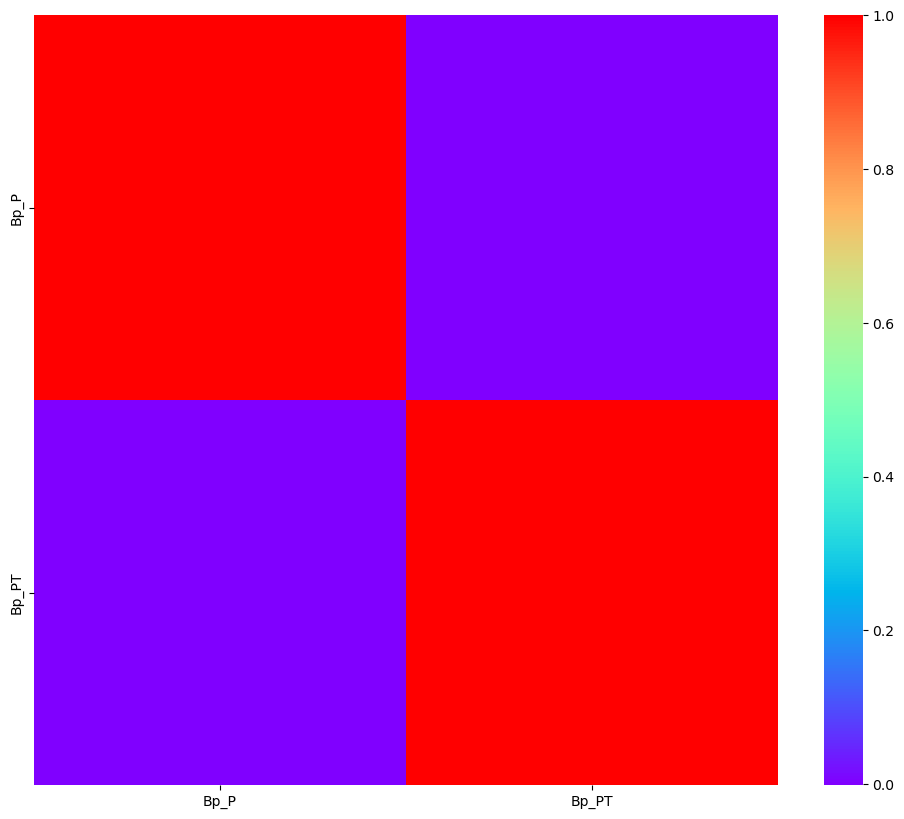

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
corr = bg_data[["Bp_P", "Bp_PT"]].corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True, ax=ax, cmap="rainbow")

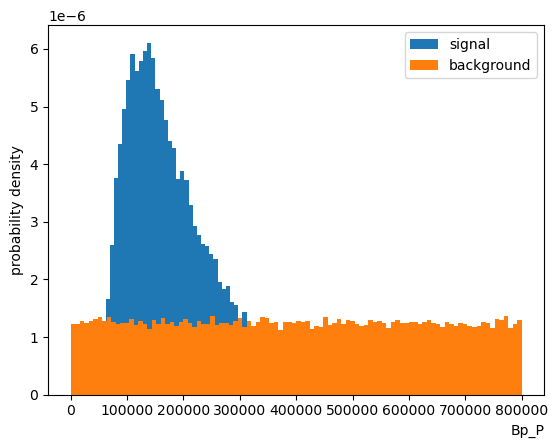

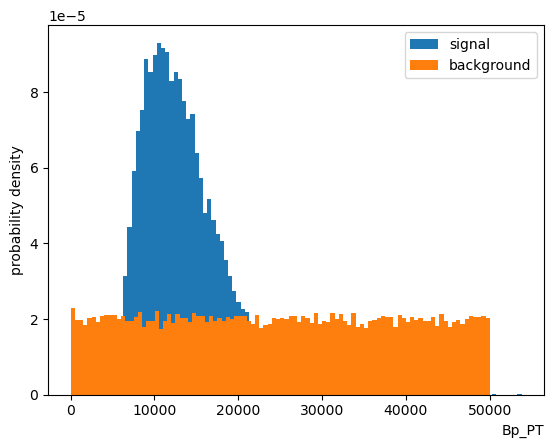

In [46]:
bins = 100
for variable in ["Bp_P", "Bp_PT"]:
    fig, ax = plt.subplots()
    ax.hist(signal_data[variable], bins=bins, label="signal", density=True)
    ax.hist(bg_data[variable], bins=bins, label="background", density=True)
    ax.set_xlabel(variable, loc="right")
    ax.set_ylabel("probability density")
    ax.legend()

#### 超参数优化

在正式训练前，可以使用`GridSearchCV`或`RandomizedSearchCV`等方法来进行超参数优化，以提升模型的性能。

In [47]:
model = xgb.XGBClassifier(device=f"cuda:0")

In [48]:
param_grid = [
    {
        "learning_rate": [0.1, 0.3, 0.5],
        "max_depth": [2],
        # "gamma": [0, 1, 2],
        # "min_child_weight": [0.5, 1, 1.5],
    },
]

In [49]:
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3)

In [50]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END ....learning_rate=0.1, max_depth=2;, score=0.894 total time=   0.6s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END ....learning_rate=0.1, max_depth=2;, score=0.895 total time=   0.7s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END ....learning_rate=0.1, max_depth=2;, score=0.892 total time=   0.5s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END ....learning_rate=0.1, max_depth=2;, score=0.897 total time=   0.6s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END ....learning_rate=0.1, max_depth=2;, score=0.895 total time=   0.5s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END ....learning_rate=0.3, max_depth=2;, score=0.898 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/5] END ....learning_rate=0.3, max_depth=2;, score=0.898 total time=   0.2s
[CV 3/5] END ....learning_rate=0.3, max_depth=2;, score=0.896 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 4/5] END ....learning_rate=0.3, max_depth=2;, score=0.901 total time=   0.2s
[CV 5/5] END ....learning_rate=0.3, max_depth=2;, score=0.897 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/5] END ....learning_rate=0.5, max_depth=2;, score=0.898 total time=   0.2s
[CV 2/5] END ....learning_rate=0.5, max_depth=2;, score=0.896 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/5] END ....learning_rate=0.5, max_depth=2;, score=0.896 total time=   0.2s
[CV 4/5] END ....learning_rate=0.5, max_depth=2;, score=0.901 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[CV 5/5] END ....learning_rate=0.5, max_depth=2;, score=0.897 total time=   0.2s


/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"[{'learning_rate': [0.1, 0.3, ...], 'max_depth': [2]}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [51]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2}

In [52]:
grid_search.cv_results_

{'mean_fit_time': array([0.56879282, 0.19552836, 0.18434091]),
 'std_fit_time': array([0.08621652, 0.01743842, 0.00212512]),
 'mean_score_time': array([0.0075284 , 0.00998507, 0.00478878]),
 'std_score_time': array([2.84909816e-03, 1.05361296e-02, 7.49633814e-05]),
 'param_learning_rate': masked_array(data=[0.1, 0.3, 0.5],
              mask=[False, False, False],
        fill_value=1e+20),
 'param_max_depth': masked_array(data=[2, 2, 2],
              mask=[False, False, False],
        fill_value=999999),
 'params': [{'learning_rate': 0.1, 'max_depth': 2},
  {'learning_rate': 0.3, 'max_depth': 2},
  {'learning_rate': 0.5, 'max_depth': 2}],
 'split0_test_score': array([0.89400127, 0.89790362, 0.89799437]),
 'split1_test_score': array([0.8952718 , 0.89763136, 0.89636083]),
 'split2_test_score': array([0.89227698, 0.89572556, 0.89590707]),
 'split3_test_score': array([0.8971776 , 0.90144296, 0.9009892 ]),
 'split4_test_score': array([0.89472729, 0.89654234, 0.89690535]),
 'mean_test_sco

In [53]:
grid_search.score(x_test, y_test)

0.9020878329733621

#### 用最佳的超参数进行k-fold训练

In [54]:
model_best = xgb.XGBClassifier(device=f"cuda:0", **grid_search.best_params_)

In [55]:
logo = LeaveOneGroupOut()

In [56]:
cv_result = cross_validate(
    model_best,
    x_train,
    y_train,
    cv=logo,
    groups=data["fold"].loc[x_train.index],
    return_estimator=True,
)
cv_result

/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/st0/lhcb/laf/scientific-python-ecosystem-tutorial/.pixi/envs/default/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:48:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work

{'fit_time': array([0.17217708, 0.18715167, 0.26207733, 0.17593908, 0.31902552]),
 'score_time': array([0.00484252, 0.00671649, 0.02944541, 0.00459385, 0.02987027]),
 'estimator': [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device='cuda:0',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.3, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, ...),
  XGBClassifier(base_

#### 定义predict函数并检查训练结果

In [57]:
def cv_predict_proba(
    x: pd.DataFrame, *, models: list[xgb.XGBClassifier], folds: np.ndarray
) -> np.ndarray:
    return np.choose(folds, [model.predict_proba(x)[:, 1] for model in models])


def cv_predict(
    x: pd.DataFrame, *, models: list[xgb.XGBClassifier], folds: np.ndarray
) -> np.ndarray:
    return np.choose(folds, [model.predict(x) for model in models])

In [58]:
prediction = cv_predict(
    x_test,
    models=cv_result["estimator"],
    folds=data["fold"].loc[x_test.index].to_numpy(),
)
accuracy_score(y_test, prediction)

0.9017066869944522

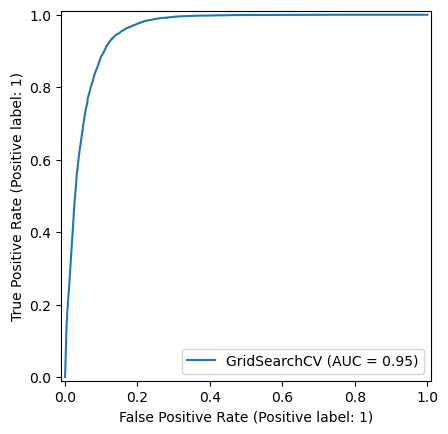

In [59]:
RocCurveDisplay.from_estimator(grid_search, x_test, y_test)

In [60]:
import matplotlib.patches as mpatches
import scipy

In [61]:
def overtrain_check(*, prediction_func, bins=20, yscale="log", training_variables):
    data_train = pd.concat((x_train, y_train), axis="columns")
    data_train_sig = data_train.query("label == 1")[training_variables]
    data_train_bkg = data_train.query("label == 0")[training_variables]
    prediction_train_sig = prediction_func(data_train_sig)
    prediction_train_bkg = prediction_func(data_train_bkg)

    data_test = pd.concat((x_test, y_test), axis="columns")
    data_test_sig = data_test.query("label == 1")[training_variables]
    data_test_bkg = data_test.query("label == 0")[training_variables]
    prediction_test_sig = prediction_func(data_test_sig)
    prediction_test_bkg = prediction_func(data_test_bkg)

    fig, ax = plt.subplots()

    ax.hist(
        prediction_train_sig,
        range=(0, 1),
        bins=bins,
        density=True,
        color="xkcd:azure",
        alpha=0.5,
        # color="w",
        # edgecolor="xkcd:azure",
        # hatch="/",
        label="Signal (training sample)",
    )

    ax.hist(
        prediction_train_bkg,
        range=(0, 1),
        bins=bins,
        density=True,
        color="orangered",
        alpha=0.5,
        # color="w",
        # edgecolor="orangered",
        # hatch="/",
        label="Background (training sample)",
    )

    hist_test_sig, hist_test_sig_binedges = np.histogram(
        prediction_test_sig,
        range=(0, 1),
        bins=bins,
        density=True,
    )
    hist_test_sig_x = (hist_test_sig_binedges[:-1] + hist_test_sig_binedges[1:]) / 2
    ax.errorbar(
        hist_test_sig_x,
        hist_test_sig,
        xerr=1 / bins / 2,
        fmt="o",
        capsize=2,
        color="xkcd:azure",
        alpha=0.5,
        markersize=4,
        label="Signal (test sample)",
    )

    hist_test_bkg, hist_test_bkg_binedges = np.histogram(
        prediction_test_bkg,
        range=(0, 1),
        bins=bins,
        density=True,
    )
    hist_test_bkg_x = (hist_test_bkg_binedges[:-1] + hist_test_bkg_binedges[1:]) / 2
    ax.errorbar(
        hist_test_bkg_x,
        hist_test_bkg,
        xerr=1 / bins / 2,
        fmt="o",
        capsize=2,
        color="orangered",
        alpha=0.5,
        markersize=4,
        label="Backgrond (test sample)",
    )

    handles, labels = ax.get_legend_handles_labels()
    empty_patch_sig = mpatches.Patch(
        color="none",
        label=f"Signal KS-test p-value: {round(scipy.stats.kstest(prediction_train_sig, prediction_test_sig).pvalue, 3)}",
    )
    empty_patch_bkg = mpatches.Patch(
        color="none",
        label=f"Background KS-test p-value: {round(scipy.stats.kstest(prediction_train_bkg, prediction_test_bkg).pvalue, 3)}",
    )
    handles += [empty_patch_sig, empty_patch_bkg]

    ax.legend(handles=handles, loc="upper center")
    ax.set_xlabel("MVA response", loc="right")
    ax.set_ylabel("probability density")
    ax.set_yscale(yscale)

    print(scipy.stats.kstest(prediction_train_sig, prediction_test_sig))
    print(scipy.stats.kstest(prediction_train_bkg, prediction_test_bkg))

KstestResult(statistic=np.float64(0.008609351743117999), pvalue=np.float64(0.5696011053455723), statistic_location=np.float32(0.8349976), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.01186974793888379), pvalue=np.float64(0.19308874638010087), statistic_location=np.float32(0.00813964), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.008609351743117999), pvalue=np.float64(0.5696011053455723), statistic_location=np.float32(0.8349976), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.01186974793888379), pvalue=np.float64(0.19308874638010087), statistic_location=np.float32(0.00813964), statistic_sign=np.int8(-1))


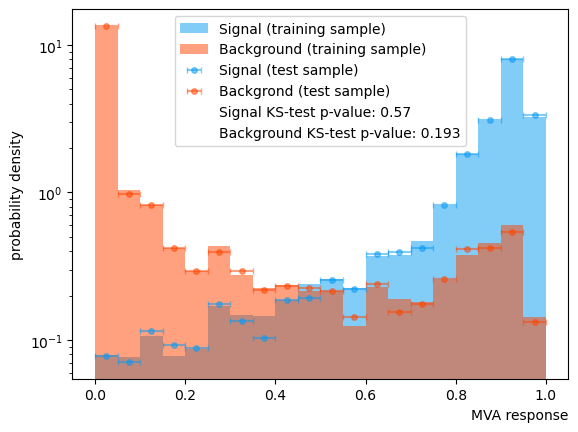

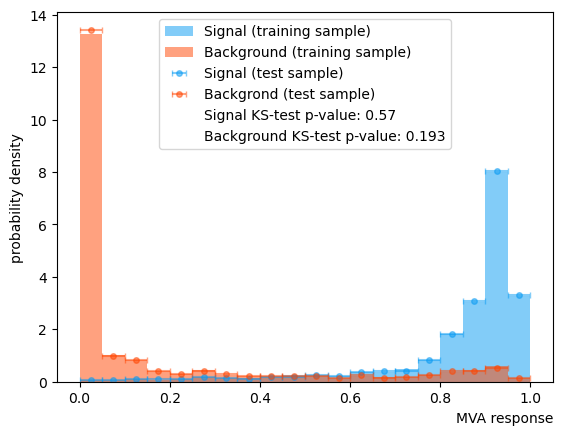

In [62]:
overtrain_check(
    prediction_func=lambda x: cv_predict_proba(
        x, models=cv_result["estimator"], folds=data["fold"].loc[x.index]
    ),
    bins=20,
    yscale="log",
    training_variables=["Bp_P", "Bp_PT"],
)
overtrain_check(
    prediction_func=lambda x: cv_predict_proba(
        x, models=cv_result["estimator"], folds=data["fold"].loc[x.index]
    ),
    bins=20,
    yscale="linear",
    training_variables=["Bp_P", "Bp_PT"],
)

#### 保存模型

In [63]:
import pickle

with open("model.pkl", "wb") as of:
    pickle.dump(cv_result["estimator"], of)

## 最后的一些小提示

- 在使用`pandas`进行数据处理时，尽量使用向量化的操作，避免使用`apply`等低效的函数
- 除了ROOT文件外，还可以考虑使用其他格式的数据文件，如HDF5、Parquet等，这些格式在读写速度和存储效率上有时可能更有优势
- 除特殊情况外，不要使用ROOT的`Branch`、`SetBranchAddress`然后循环的方式来处理数据，这是很低效的做法
- 不建议使用ROOT里的TMVA进行多变量分析，TMVA的维护情况差，效率低，使用不友好，建议使用scikit-learn、XGBoost等现代机器学习库
- 多尝试不同的工具和方法，找到最适合自己需求的解决方案